In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # optional: shows progress bar

In [2]:
# Load your CSV
coil_data = pd.read_csv(
    "combined_good_coil_data_added gauge target and phases_Gauge lst 0.08_std4.csv"
)

In [3]:
coil_data = coil_data.dropna()

In [4]:
coil_data["STD4_ID"] = pd.to_numeric(coil_data["STD4_ID"], errors="coerce").astype(
    "Int64"
)

In [5]:
coil_data

,Coil ID,Coil Length [30ms],Master Ramp,Shape Target Second Coefficient,Stand 1 Predicted Run Force,Stand 1 Gap Stick Offset,Tension Reel Calculated Tension,Stand 1-2 Total Tension Feedback,Stand 3 - Operator Side Force,Stand 1 Run Gap Setpoint,...,Roll Force Hydraulics Pressure Feedback,Stand 1 Roll Force,Stand 1 Roll Force limit (g67 delayed 200 ms + g80),Stand 1 Roll Force Increase Limit (based on predicted run force),Stand 4 OS Bending Shape Trim,Stand 4 DS Bending Shape Trim,Shape Target Second Coefficient.1,X4 Gauge Target,Phase,STD4_ID
1039,5399575,85.666664,30.444996,10.0,1595.0,0.0,9.318997,50.488003,665.78430,50.699950,...,2986.3333,1634.3,1796.7,159.0,-96.063750,-19.597168,10.0,-0.059652,Phase 1,2804528
1040,5399575,86.666664,30.733997,10.0,1595.0,0.0,9.284991,49.718000,667.42240,50.699950,...,2985.0000,1637.1,1793.3,159.0,-96.044050,-19.622883,10.0,-0.055152,Phase 1,2804528
1041,5399575,87.750000,31.013000,10.0,1595.0,0.0,9.277002,49.241005,665.48470,50.699950,...,2985.0000,1631.9,1787.7,159.0,-96.023330,-19.668726,10.0,-0.054576,Phase 1,2804528
1042,5399575,89.000000,31.291004,10.0,1595.0,0.0,9.293997,49.341007,677.53613,50.699950,...,2984.3333,1626.8,1794.4,159.0,-96.003230,-19.738321,10.0,-0.052992,Phase 1,2804528
1043,5399575,90.000000,31.569006,10.0,1595.0,0.0,9.298990,49.173996,681.52155,50.699950,...,2984.3333,1636.5,1797.1,159.0,-95.978620,-19.807482,10.0,-0.038664,Phase 1,2804528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1241903,5483932,6778.333500,16.869007,1.0,1317.0,0.0,6.996997,41.745995,456.35892,54.399902,...,2991.3333,1068.4,1361.4,300.0,-29.414700,36.314476,1.0,-0.027544,Phase 3,2836843
1241904,5483932,6779.000000,16.717993,1.0,1317.0,0.0,7.029999,41.699993,458.84305,54.399902,...,2992.3333,1070.9,1361.0,300.0,-29.330198,36.369217,1.0,-0.018920,Phase 3,2836843
1241905,5483932,6780.000000,16.539007,1.0,1317.0,0.0,7.073004,42.234000,461.86813,54.399902,...,2993.2500,1074.7,1365.8,300.0,-29.236061,36.404526,1.0,-0.022792,Phase 3,2836843
1241906,5483932,6781.000000,16.322002,1.0,1317.0,0.0,7.113996,41.733997,462.17070,54.399902,...,2994.6667,1078.9,1369.4,300.0,-29.157320,36.391160,1.0,-0.026928,Phase 3,2836843


In [33]:
import numpy as np
import pandas as pd
from tqdm import tqdm


def detect_anomalies_add_flag(
    df, signal_cols, x_col="Coil Length [30ms]", window=100, z_thresh=2
):
    """
    Adds an 'Anomaly Flag' column based on rolling window z-score.
    Works per coil and phase, for the specified signal(s).
    """
    df_sorted = (
        df.sort_values(["STD4_ID", "Phase", x_col]).reset_index(drop=True).copy()
    )
    df_sorted["Anomaly Flag"] = 0  # initialize

    for coil_id in tqdm(df_sorted["STD4_ID"].unique(), desc="Processing Coils"):
        coil_df_idx = df_sorted["STD4_ID"] == coil_id
        coil_df = df_sorted[coil_df_idx]

        for phase in coil_df["Phase"].unique():
            phase_idx = coil_df["Phase"] == phase
            phase_df = coil_df[phase_idx]

            for signal_col in signal_cols:
                series = phase_df[signal_col]

                # rolling mean & std
                rolling_mean = series.rolling(window=window, center=True).mean()
                rolling_std = series.rolling(window=window, center=True).std()

                # compute z-score
                z_score = (series - rolling_mean) / (rolling_std + 1e-9)

                # detect anomalies
                anomalies = z_score.abs() > z_thresh

                # set anomaly flag
                df_sorted.loc[coil_df_idx & phase_idx & anomalies, "Anomaly Flag"] = 1

    return df_sorted


# --- Input Coil & Signal ---
coil_id = 2804656
signal_cols = ["Stand 4 OS Roll Force"]

# Filter data for selected coil
coil_df = coil_data[coil_data["STD4_ID"] == coil_id].copy()

# Run anomaly detection
final_df = detect_anomalies_add_flag(
    coil_df, signal_cols=signal_cols, x_col="Coil Length [30ms]", window=100, z_thresh=2
)

# Select only required columns
cols_to_export = (
    ["Coil ID", "STD4_ID", "Phase", "Coil Length [30ms]"]
    + signal_cols
    + ["Anomaly Flag"]
)
final_export = final_df[cols_to_export]

# --- Save CSV ---
signal_name = signal_cols[0].replace(" ", "_")
output_file = f"{coil_id}_{signal_name}_AnomalyFlag.csv"
final_export.to_csv(output_file, index=False)

print(f"Saved CSV: {output_file}")

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_9748\2892519908.py:37: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  df_sorted.loc[coil_df_idx & phase_idx & anomalies, "Anomaly Flag"] = 1
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_9748\2892519908.py:37: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  df_sorted.loc[coil_df_idx & phase_idx & anomalies, "Anomaly Flag"] = 1
C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_9748\2892519908.py:37: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  df_sor

Saved CSV: 2804656_Stand_4_OS_Roll_Force_AnomalyFlag.csv


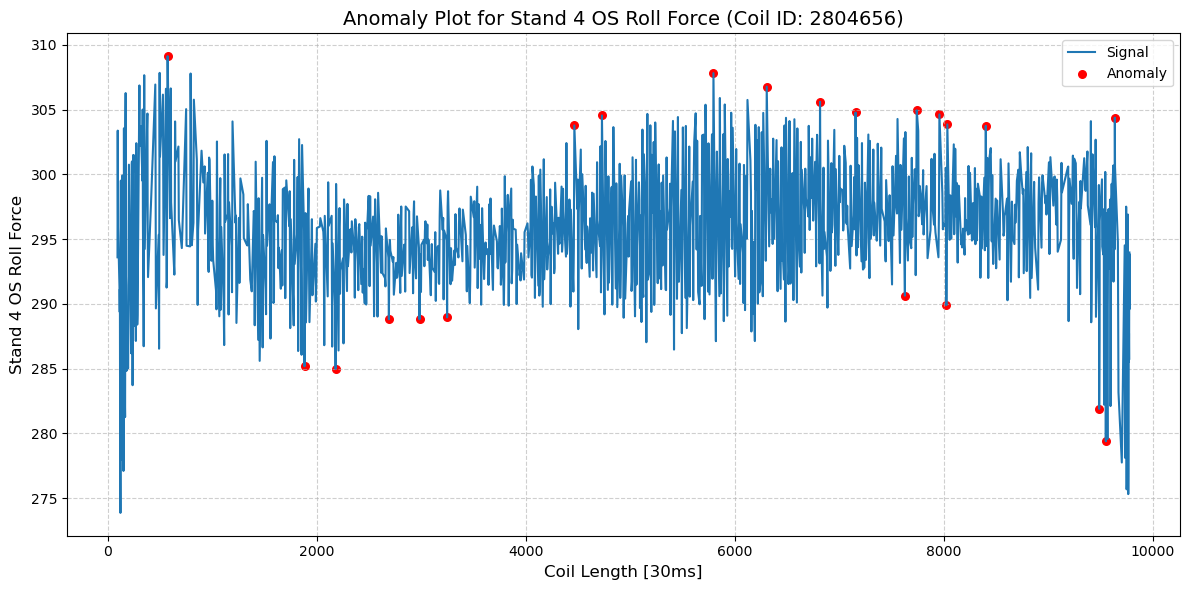

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Load your saved CSV ---
csv_file = "2804656_Stand_4_OS_Roll_Force_AnomalyFlag.csv"
df = pd.read_csv(csv_file)

signal_col = "Stand 4 OS Roll Force"
x_col = "Coil Length [30ms]"

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(df[x_col], df[signal_col], label="Signal", linewidth=1.5)

# Highlight anomalies (flag == 1)
anomalies = df[df["Anomaly Flag"] == 1]
plt.scatter(anomalies[x_col], anomalies[signal_col], color="red", s=30, label="Anomaly")

plt.title(
    f"Anomaly Plot for {signal_col} (Coil ID: {df['STD4_ID'].iloc[0]})", fontsize=14
)
plt.xlabel(x_col, fontsize=12)
plt.ylabel(signal_col, fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

coil_id = 2804656
signal_cols = ["Stand 4 OS Roll Force"]

# Power BI automatically provides this filtered dataset
df = coil_data[coil_data["STD4_ID"] == coil_id].copy()

# --- Rename / identify key columns (adjust these if your names differ) ---
coil_col = "Coil ID"
phase_col = "Phase"
x_col = "Coil Length"
signal_name_col = signal_cols  # text column
signal_value_col = signal_cols  # numeric column

# Ensure numeric type
df[signal_value_col] = pd.to_numeric(df[signal_value_col], errors="coerce")

# Sort
df = df.sort_values([coil_col, phase_col, x_col]).reset_index(drop=True)

# Initialize anomaly flag
df["Anomaly Flag"] = 0

# Rolling window anomaly detection per signal & phase
window = 100
z_thresh = 2

for (sig, phase), sub_df in df.groupby([signal_name_col, phase_col]):
    series = sub_df[signal_value_col]
    rolling_mean = series.rolling(window=window, center=True).mean()
    rolling_std = series.rolling(window=window, center=True).std()
    z_score = (series - rolling_mean) / (rolling_std + 1e-9)
    anomalies = z_score.abs() > z_thresh
    df.loc[sub_df.index, "Anomaly Flag"] = anomalies.astype(int)

# --- Plot ---
plt.figure(figsize=(10, 5))

for sig in df[signal_name_col].unique():
    sig_df = df[df[signal_name_col] == sig]
    plt.plot(sig_df[x_col], sig_df[signal_value_col], label=f"{sig}", linewidth=1.5)
    plt.scatter(
        sig_df.loc[sig_df["Anomaly Flag"] == 1, x_col],
        sig_df.loc[sig_df["Anomaly Flag"] == 1, signal_value_col],
        color="red",
        s=35,
        label=f"{sig} anomalies",
    )

coil_id = df[coil_col].iloc[0] if not df.empty else "Unknown"
plt.xlabel(x_col)
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
plt.tight_layout()

TypeError: arg must be a list, tuple, 1-d array, or Series